# Imports

The code above imports various Python modules and libraries for data processing, visualization, and analysis. Below is a description of each module and library imported:

- `os`: Provides a way to interact with the operating system, such as navigating directories and working with files.
- `ast`: Provides a way to parse Python code into an abstract syntax tree, which can be used to analyze and manipulate the code.
- `spacy`: A library for natural language processing, including tasks such as tokenization, part-of-speech tagging, and named entity recognition.
- `folium`: A library for creating interactive maps using the Leaflet JavaScript library.
- `sqlite3`: A module for working with SQLite databases.
- `squarify`: A library for generating treemaps, which visualize hierarchical data using nested rectangles.
- `itertools`: Provides a collection of functions for working with iterators, such as combining multiple iterators or creating permutations.
- `webcolors`: A library for working with CSS-style color strings.
- `tqdm`: A library for creating progress bars for loops.
- `pandas`: A library for data manipulation and analysis, including reading and writing data to/from various file formats.
- `ipywidgets`: Provides interactive widgets for Jupyter notebooks and other IPython environments.
- `matplotlib.pyplot`: A library for creating visualizations, including line plots, scatter plots, bar charts, and histograms.
- `collections.Counter`: A container that keeps track of the frequency of elements in a collection.

In [1]:
import os
import ast
import spacy
import folium
import sqlite3
import datetime
import squarify
import itertools
import webcolors
import pandas as pd
from tqdm import tqdm
import ipywidgets as widgets
from collections import Counter
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim

# Settings base variables and paths

The code above sets the base folder path and creates four subdirectories within that base path: "images", "metadata", and "config". These subdirectories are created by joining the base path with their respective names using the os.path.join() function.

In [2]:
# Set the base folder path for the project
output_path = "../output"
images_path = os.path.join(output_path, "images")
metadata_path = os.path.join(output_path, "metadata")
config_path = os.path.join(output_path, "config")

list_of_paths = [output_path, images_path, metadata_path, config_path]

# Get the metadata from db and sort it with list into a dictionary

### Get the metadata from the database

The function "get_metadata_from_sqlite_DB" is used to retrieve metadata from a SQLite database. It takes an optional argument "db_name" to specify the name of the database. It opens a connection to the database, creates a cursor, and retrieves metadata for the first file in the images' directory. The metadata is stored in a dictionary format, where the filename is the key and the metadata is a list of key-value pairs. The function then closes the connection and returns the dictionary of metadata.

In [3]:

def get_metadata_from_sqlite_db(db_name='metadata.db') :
    """
    Get the metadata from the sqlite database

    :param db_name: The name of the database
    :return: A dictionary with the metadata
    """
    # Open a connection to the database
    conn = sqlite3.connect(os.path.join(metadata_path, db_name))

    # Create a cursor
    c = conn.cursor()

    # Get the name of all images in db
    metadata_file = c.execute("SELECT DISTINCT filename FROM metadata").fetchall()
    nb_images = len(metadata_file)

    # Get the metadata of the first file
    res = {}
    for file in tqdm(metadata_file, desc="Get metadata from SQLite DB"):
        c.execute("SELECT * FROM metadata WHERE filename=?", file)
        # Print the metadata
        # Convert result to format: filename: [{key: value}...]
        metadata = c.fetchall()
        result = {}
        for row in metadata:
            if row[0] not in result:
                result[row[0]] = {}
            result[row[0]][row[1]] = row[2]
        res.update(result)

    # Close the connection
    conn.close()

    return res

# Format the metadata into a dictionary

The function "format_metadata" is used to format the metadata into a dictionary. Each property is a key and the values are stored in a list. The function takes a dictionary of metadata as an argument and returns a dictionary with the formatted metadata.

In [4]:
def format_metadata(metadata_to_format):
    """
    Format the metadata into a dictionary
    Each property is a key and the values are stored in a list

    :param metadata_to_format: The metadata to format
    :return: A dictionary with the formatted metadata
    """
    # Create lists for each property
    formatted = {}

    # List all properties of the images
    prop_list = []
    for image in metadata_to_format:
        for prop in metadata_to_format[image]:
            if prop not in prop_list:
                prop_list.append(prop)

    # Add properties to the dictionary
    formatted["file"] = []
    for prop in prop_list:
        formatted[prop] = []

    # Add property values to the lists
    for image in tqdm(metadata_to_format, desc="Format metadata"):
        formatted["file"].append(image)
        for prop in prop_list:
            if prop in metadata_to_format[image]:
                formatted[prop].append(metadata_to_format[image][prop])
            else:
                formatted[prop].append(None)

    print("Metadata formatted !")
    return formatted

### Clean the metadata

The function "clean_metadata" is used to clean the metadata. It takes a dictionary of metadata as an argument and returns a dictionary with the cleaned metadata. The function removes special characters from the 'Make' property values and removes the 'T' and '-' characters from the 'DateTime' property values.

In [5]:
def clean_metadata(metadata_to_clean):
    """
    Clean the metadata
    Remove special characters from the 'Make' property values
    Remove the 'T' and '-' characters from the 'DateTime' property values

    :param metadata_to_clean: The metadata to clean
    :return: A dictionary with the cleaned metadata
    """
    cln_metadata = metadata_to_clean.copy()

    # Clean 'Make' property values
    for index in range(len(cln_metadata['Make'])):
        if cln_metadata['Make'][index] is not None:
            cln_metadata['Make'][index] = ''.join(filter(str.isalpha, cln_metadata['Make'][index])).replace('CORPORATION', '').replace('CORP', '').replace('COMPANY', '').replace('LTD', '').replace('IMAGING', '')

    # Clean 'DateTime' property values
    cpt, cpt_error = 0, 0
    date_error = []
    for j, date in enumerate(cln_metadata['DateTime']):
        try :
            if cln_metadata['DateTime'][j] is not None:
                tmp = cln_metadata['DateTime'][j].replace('T', ' ').replace('-', ':').split('+')[0]
                cln_metadata['DateTime'][j] = datetime.datetime.strptime(tmp[:19], '%Y:%m:%d %H:%M:%S')
                # if the year is after actual year, we assume that the date is wrong
                if cln_metadata['DateTime'][j].year > datetime.datetime.now().year:
                    date_error.append(cln_metadata['DateTime'][j])
                    cln_metadata['DateTime'][j] = None
                    cpt_error += 1
                else:
                    cpt += 1
        except ValueError:
                date_error.append(cln_metadata['DateTime'][j])
                cln_metadata['DateTime'][j] = None
                cpt_error += 1

    print(f"Metadata cleaned ! {cpt}/{len(cln_metadata['DateTime'])} dates OK, {cpt_error} dates KO")
    print(f"Dates KO : {date_error}")
    return cln_metadata

In [6]:
# Get the metadata from the SQLite database
brut_metadata = get_metadata_from_sqlite_db()
# Format the metadata
formatted_metadata = format_metadata(brut_metadata)
# Clean the metadata
dict_metadata = clean_metadata(formatted_metadata)

Format metadata: 100%|██████████| 4483/4483 [00:00<00:00, 82031.00it/s]

Metadata formatted !
Metadata cleaned ! 3862/4483 dates OK, 8 dates KO
Dates KO : [datetime.datetime(2037, 12, 31, 23, 59, 59), '2012:04:10 15:04:96', datetime.datetime(2050, 1, 7, 0, 14, 20), '                   ', '                   ', '0000:00:00 00:00:00', '                   ', '                   ']


### Overview of the metadata

The function "count_data_per_property" is used to count the number of non-null values for each property in the metadata dictionary. It takes a dictionary of metadata as an argument and prints the properties that have more than 70 non-null values.

The function "metadata_extract_example" is used to print the first 3 elements of each list in the dict_metadata dictionary. It takes a dictionary of metadata as an argument and prints the first 3 elements of each list in the dict_metadata dictionary.

In [7]:
def count_data_per_property(metadata_to_count, significant_limit=70):
    """
    Count the number of non-null values for each property in the metadata dictionary
    Display the properties that have significant non-null values

    :param metadata_to_count: The metadata to count
    :param significant_limit: The limit after which a property is considered significant
    """
    # Count the number of non-null values for each property in the metadata dictionary
    prop_len = {}
    for prop in metadata_to_count:
        prop_len[prop] = len([x for x in metadata_to_count[prop] if x is not None])

        # Print the properties that have more than 70 non-null values
        if prop_len[prop] > significant_limit:
            print(f'{prop} : {prop_len[prop]}')

def metadata_extract_example(metadata, significant_limit=70):
    """
    Print the first 3 elements of each list in the dict_metadata dictionary
    Do not print the "MakerNote" property (too long)

    :param metadata: The metadata to print
    :param significant_limit: The limit after which a property is considered significant
    """
    # Print the first 3 elements of each list in the dict_metadata dictionary
    for prop in metadata:
        # Only print properties that have more than 70 non-null values and are not "MakerNote"
        if len(metadata[prop]) > significant_limit and prop != "MakerNote":
            print(f'{prop} : {metadata[prop][:3]}')

In [8]:
print(f'Number of images : {len(dict_metadata["file"])}')
print("-------------- Properties with more significant non-null values --------------")
count_data_per_property(formatted_metadata)
print("-------------- First 3 elements of each list in the dict_metadata dictionary --------------")
metadata_extract_example(dict_metadata)

Number of images : 4483
-------------- Properties with more significant non-null values --------------
file : 4483
ResolutionUnit : 4040
ExifOffset : 4276
Make : 3924
Model : 3923
Software : 3960
DateTime : 3862
XResolution : 4055
YResolution : 4057
ExifVersion : 4024
ShutterSpeedValue : 3671
ApertureValue : 3602
DateTimeOriginal : 3963
DateTimeDigitized : 3789
ExposureBiasValue : 3833
MaxApertureValue : 3461
MeteringMode : 3847
ColorSpace : 3760
Flash : 3858
FocalLength : 3804
ExposureMode : 3697
WhiteBalance : 3713
SceneCaptureType : 3753
FocalPlaneXResolution : 2746
FocalPlaneYResolution : 2746
FocalPlaneResolutionUnit : 2755
SubsecTimeOriginal : 2499
SubsecTimeDigitized : 2327
ExposureTime : 3886
FNumber : 3802
ExposureProgram : 3818
CustomRendered : 3448
ISOSpeedRatings : 3875
SensitivityType : 2844
BodySerialNumber : 2473
RecommendedExposureIndex : 1886
LensSpecification : 3091
LensModel : 3342
LensSerialNumber : 1496
width : 4368
height : 4368
tags : 4480
ImageDescription : 573


# Define the functions to display the metadata

- "display_bar" is used to display a bar chart.
- "display_pie" is used to display a pie chart.
- "display_curve" is used to display a curve chart.

In [9]:
def display_bar(title, x_label, y_label, x_values, y_values):
    """
    Display a bar chart

    :param title: The title of the chart
    :param x_label: The x-axis label
    :param y_label: The y-axis label
    :param x_values: The values of the x-axis
    :param y_values: The values of the y-axis
    """
    plt.bar(x_values, y_values)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=90)
    plt.show()

In [10]:
def display_pie(title, values, labels):
    """
    Display a pie chart

    :param title: The title of the chart
    :param values: The values of the chart
    :param labels: The labels of the chart
    """
    plt.pie(values, labels=labels, autopct='%1.1f%%')
    plt.title(title)
    plt.show()

In [11]:
def display_curve(title, x_label, y_label, x_values, y_values):
    """
    Display a curve

    :param title: The title of the curve
    :param x_label: The label of the x_axis
    :param y_label: The label of the y_axis
    :param x_values: The values of the x_axis
    :param y_values: The values of the y_axis
    """

    plt.plot(x_values, y_values)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

# Graph images : size (static)

The function "graph_images_size_static" is used to graph the number of images per size category. It takes a dictionary of metadata as an argument and returns a graph with the number of images per size category. The interval size is 200 by default.


In [12]:
def graph_images_size_static(metadata, interval_size=200, nb_intervals=4):
    """
    Graph the number of images per size category
    The interval size is 200 by default

    :param metadata: The metadata to graph
    :param interval_size: The size of the intervals
    :param nb_intervals: The number of intervals
    """
    # Convert metadata to a DataFrame
    df = pd.DataFrame(metadata)

    # Calculate the minimum size of each image and store it in a new column
    df['min_size'] = df[['width', 'height']].min(axis=1)

    # Determine the maximum minimum size
    max_min_size = df['min_size'].max()

    # Create a list of intervals based on the interval size and number of intervals
    inter = [i * interval_size for i in range(nb_intervals + 1)]

    # Create a list of labels for each interval
    labels = [f'{inter[i]}-{inter[i + 1]}' for i in range(nb_intervals)]

    # Categorize each image based on its size and interval
    df['size_category'] = pd.cut(df['min_size'], bins=inter, labels=labels)


    # Count the number of images in each category
    size_counts = df['size_category'].value_counts()


    display_bar('Number of images per size category', 'Size category', 'Number of images', size_counts.index, size_counts.values)

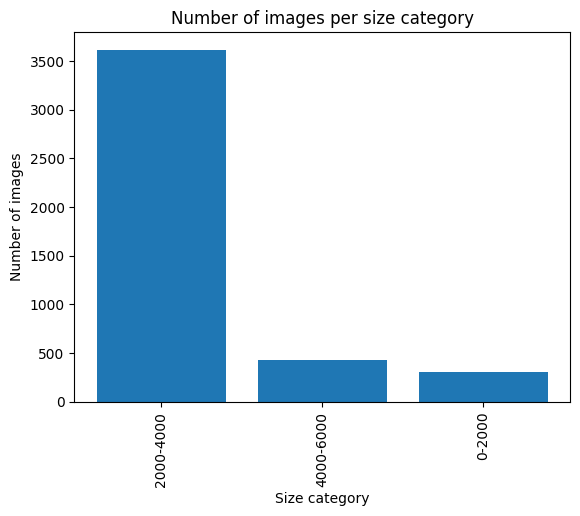

In [13]:
graph_images_size_static(dict_metadata, 2000, 3)

# Graph images : size (dynamic)

The function "graph_images_size_dynamic" is used to graph the number of images per size category. It takes a dictionary of metadata as an argument and returns a graph with the number of images per size category. The interval size is calculated dynamically. The number of columns in the graph is 7 by default.

You can choose the type of graph to display (bar, pie or all for both).

In [14]:
def graph_images_size_dynamic(metadata, nb_intervals=7, graph_type='all'):
    """
    Graph the number of images per size category
    The interval size is calculated dynamically

    :param metadata: The metadata to graph
    :param nb_intervals: The number of intervals in the graph
    :param graph_type: The type of graph to display (bar, pie or all for both)
    """

    # Convert metadata to a DataFrame
    df = pd.DataFrame(metadata)

    # Calculate the minimum size of each image and store it in a new column
    df['min_size'] = df[['height', 'width']].min(axis=1)

    # Determine the maximum minimum size and calculate the number of bins dynamically based on the number of columns
    max_min_size = df['min_size'].max()
    num_images = len(df)
    num_bins = int(num_images / (num_images / nb_intervals))

    # Create a list of bins based on the maximum minimum size and number of bins
    bins = [i * (max_min_size / num_bins) for i in range(num_bins + 1)]

    # Create a list of labels for each bin
    labels = [f'{int(bins[i])}-{int(bins[i + 1])}' for i in range(num_bins)]

    # Categorize each image based on its size and bin
    df['size_category'] = pd.cut(df['min_size'], bins=bins, labels=labels)

    # Count the number of images in each category
    size_counts = df['size_category'].value_counts()

    title = 'Number of images per size category'

    # Create the appropriate chart based on the graph type parameter
    if graph_type == 'bar':
        display_bar(title, 'Image size', 'Number of images', size_counts.index, size_counts.values)
    elif graph_type == 'pie':
        display_pie(title, size_counts.values, size_counts.index)
    elif graph_type == 'all':
        display_bar(title, 'Image size', 'Number of images', size_counts.index, size_counts.values)
        display_pie(title, size_counts.values, size_counts.index)

    else:
        raise ValueError('Invalid graph type')


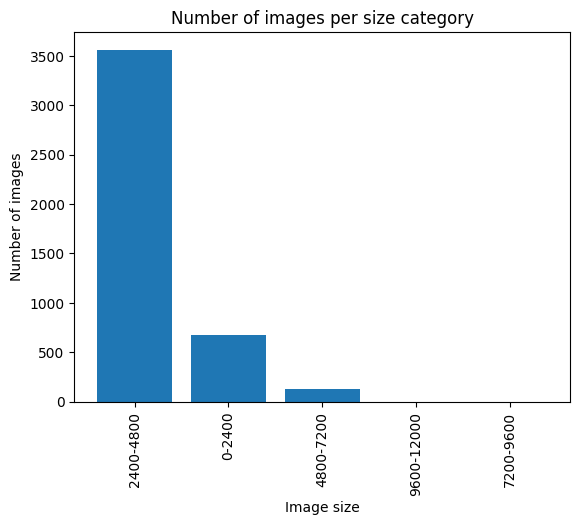

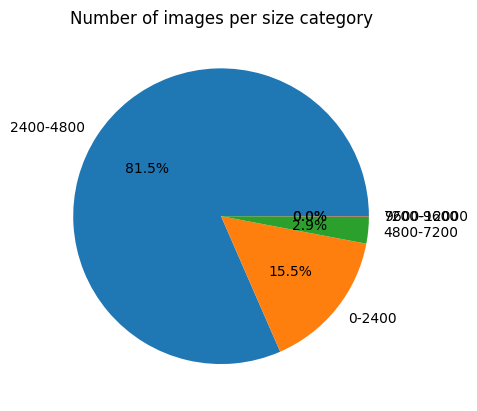

In [15]:
graph_images_size_dynamic(dict_metadata, 5, 'all')

# Graph images : DateTime

The function "graph_images_datetime" is used to graph the number of images per year. It takes a dictionary of metadata as an argument and returns a graph with the number of images per year.

You can choose the type of graph to display (bar, pie, curve or all for all).


In [16]:
def graph_images_datetime(metadata, nb_intervals=10, graph_type='all'):
    """
    Graph the number of images per year

    :param metadata: The metadata to graph (expects a list of dictionaries)
    :param graph_type: The type of graph to display (bar, pie, curve or all for all)
    :param nb_intervals: The number of intervals to display
    """

    # Convert metadata to a DataFrame
    df = pd.DataFrame(metadata)

    # Extract year from the 'DateTime' column and create a new 'Year' column
    df['Year'] = pd.DatetimeIndex(df['DateTime']).year

    # Group the data by year and count the number of images for each year
    image_count = df.groupby('Year').size().reset_index(name='count').sort_values('count', ascending=False)[:nb_intervals]
    image_count['Year'] = image_count['Year'].astype(int)

    # Set the title of the graph
    title = 'Number of images per year'

    # Display different types of graphs based on the 'graph_type' parameter
    if graph_type == 'bar':
        # Display a bar chart
        image_count.plot(kind='bar', x='Year', y='count')
        display_bar(title, 'Year', 'Number of images', image_count['Year'], image_count['count'])

    elif graph_type == 'pie':
        # Display a pie chart using a custom function 'display_pie'
        display_pie(title, image_count['count'], image_count['Year'])

    elif graph_type == 'curve':
        # Display a line chart using a custom function 'display_curve'
        image_count = df.groupby('Year').size().reset_index(name='count').sort_values('Year', ascending=True)
        display_curve(title, 'Year', 'Number of images', image_count['Year'], image_count['count'])

    elif graph_type == 'all':
        # Display all three types of graphs: bar, pie, and line charts

        # Bar chart
        image_count.plot(kind='bar', x='Year', y='count')
        display_bar(title, 'Year', 'Number of images', image_count['Year'], image_count['count'])

        # Pie chart
        display_pie(title, image_count['count'], image_count['Year'])

        # Line chart
        image_count = df.groupby('Year').size().reset_index(name='count').sort_values('Year', ascending=True)
        display_curve(title, 'Year', 'Number of images', image_count['Year'], image_count['count'])
    else:
        # Raise an error if an invalid 'graph_type' parameter is passed
        raise ValueError('Invalid graph type')

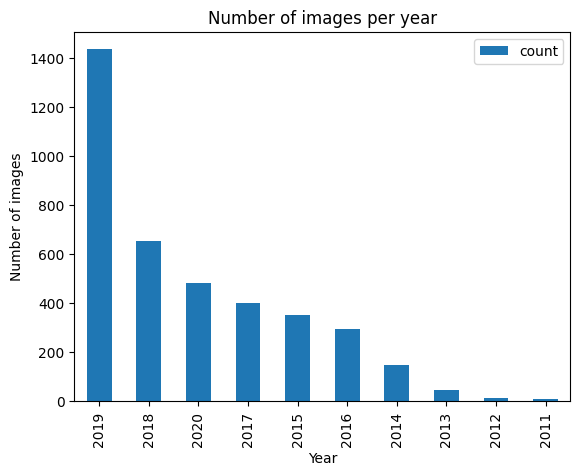

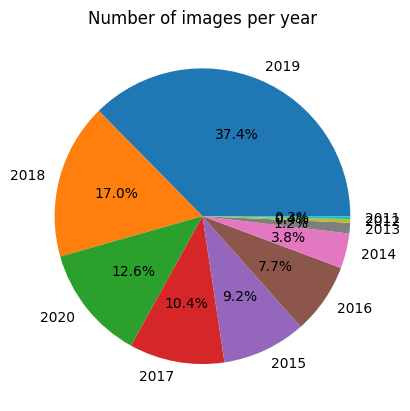

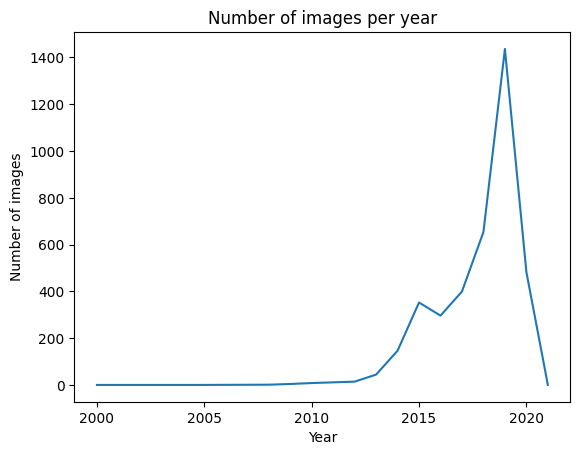

In [17]:
graph_images_datetime(dict_metadata, 10, 'all')

# Graph images : Brand

The function "graph_images_brand" is used to graph the number of images per brand. It takes a dictionary of metadata as an argument and returns a graph with the number of images per brand.

You can choose the type of graph to display (bar, pie or all for both), and the number of columns to display.

In [18]:
def graph_images_brand(metadata, graph_type='all', nb_columns=5):
    """
    Graph the number of images per brand

    :param metadata: The metadata to graph
    :param graph_type: The type of graph to display (bar, pie or all for both)
    :param nb_columns: The number of columns to display
    """

    # Initialize an empty dictionary to store the counts of each brand
    counts = {}

    # Loop through each brand in the metadata and count the number of occurrences
    for make in metadata['Make']:
        if make is not None:
            counts[make] = counts.get(make, 0) + 1

    sorted_counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))

    # Convert the dictionary into two lists of labels and values for graphing
    labels = list(sorted_counts.keys())[:nb_columns]
    values = list(sorted_counts.values())[:nb_columns]

    # Set the title for the graph
    title = 'Number of images per brand'

    # Determine which type of graph to display based on the 'graph_type' parameter
    if graph_type == 'bar':
        # Display a bar graph
        display_bar(title, 'Brand', 'Number of images', labels, values)
    elif graph_type == 'pie':
        # Display a pie chart
        display_pie(title, values, labels)
    elif graph_type == 'all':
        # Display both a bar graph and a pie chart
        display_bar(title, 'Brand', 'Number of images', labels, values)
        display_pie(title, values, labels)
    else:
        # Raise an error if the 'graph_type' parameter is invalid
        raise ValueError('Invalid graph type')

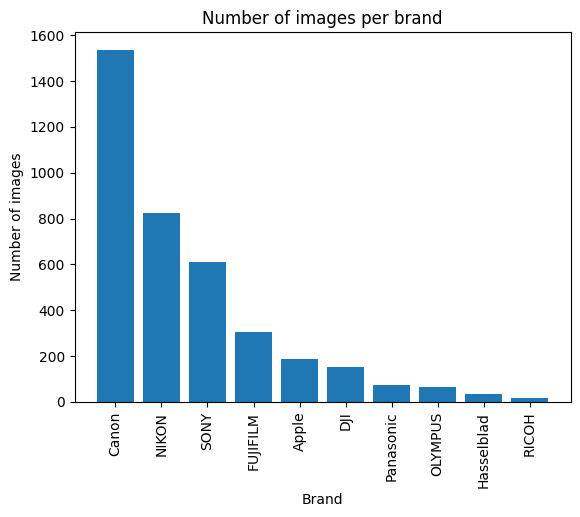

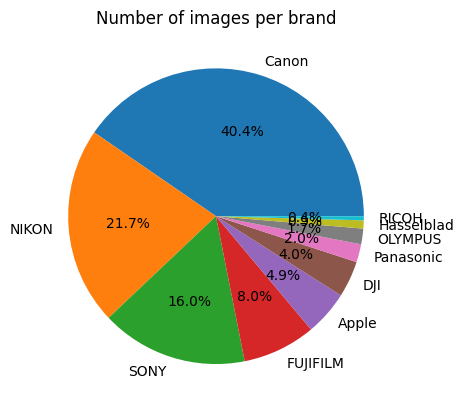

In [19]:
graph_images_brand(dict_metadata, 'all', 10)

# Graph images : Images with GPS

#### Overview

The function "gps_info_overview" is used to display the number of images with GPS data. It takes a dictionary of metadata as an argument and returns the number of images with GPS data.

In [20]:
def gps_info_overview():
    """
    Display the number of images with GPS data
    """
    cpt = 0
    # get images with GPS data and print it name and the GPS data
    for idx, meta in enumerate(dict_metadata['GPSInfo']):
        if meta is not None and len(meta) > 24:
            # print(dict_metadata['file'][idx])
            # print(meta)
            cpt += 1
    print(f"Number of images with GPS data : {cpt}")


In [21]:
gps_info_overview()

Number of images with GPS data : 298


### Extract GPS coordinates

The function "get_coordinates" is used to extract the coordinates of the images with GPS data. It takes a dictionary of metadata as an argument and returns a dictionary with the coordinates of the images with GPS data.

It uses the function "dms_to_dd" to convert the coordinates from DMS (degrees, minutes, seconds) to DD (decimal degrees).

In [22]:
def dms_to_dd(degrees, minutes, seconds, direction):
    """
    Convert DMS (degrees, minutes, seconds) coordinates to DD (decimal degrees)

    :param degrees: degrees
    :param minutes: minutes
    :param seconds: seconds
    :param direction: direction (N, S, E, W)
    :return: decimal degrees
    """

    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60)
    if direction == 'S' or direction == 'W':
        dd *= -1
    return dd

In [23]:
def get_coordinates(metadata):
    """
    Extract the coordinates of the images with GPS data

    :param metadata: The metadata to extract the coordinates from
    """
    coordinates = {}
    for i, gps_info in enumerate(metadata['GPSInfo']):
        if gps_info is not None:
            try :
                gps_info = eval(gps_info)
                latitude, longitude = None, None
                for key, val in gps_info.items():
                    if val == 'N' or val == 'S':
                        nxt = gps_info[key + 1]
                        latitude = dms_to_dd(nxt[0], nxt[1], nxt[2], val)
                    elif val == 'E' or val == 'W':
                        nxt = gps_info[key + 1]
                        longitude = dms_to_dd(nxt[0], nxt[1], nxt[2], val)

                if latitude is not None and longitude is not None :
                    coordinates.update({dict_metadata['file'][i] : [latitude, longitude]})
            except:
                print(f"Error with {dict_metadata['file'][i]}")
                # print(gps_info)
    print(f"Number of images with valid GPS data : {len(coordinates)}")

    return coordinates

In [24]:
coordinates = get_coordinates(dict_metadata)

Error with image_v6EOG98Zp6s.jpg
Error with image_7xYdOPDfNcE.jpg
Error with image_gC-sk9Je0oA.jpg
Number of images with valid GPS data : 271


### Using a Map with markers

The function "display_coordinates_on_map" is used to display the coordinates of the images with GPS data on a map. It takes a dictionary of coordinates as an argument and returns a map with the coordinates displayed as markers.

Inside the method comments, you can find a way to display the images as markers instead of the default markers.

In [25]:
def display_coordinates_on_map(coordinates_list) :
    """
    Display the coordinates on a map

    :param coordinates_list: The coordinates to display
    :return: The map with the coordinates displayed as markers
    """

    # create a map centered at a specific location
    m = folium.Map(location=[0, 0], zoom_start=1)

    # add markers for each set of coordinates
    for image, coords in coordinates_list.items():
        lat, lon = coords

        # Create a marker with the image as the icon
        # !warning! : the image must be download and you need to add :
        # from folium.features import CustomIcon

        # image_path = '../output/images/' + key
        # icon = CustomIcon(icon_image=image_path, icon_size=(100, 100))
        # folium.Marker(location=coord, icon=icon).add_to(m)
        folium.Marker(location=[lat, lon], tooltip=image, popup=f'file:{image}\ncoord:{coords}').add_to(m)
    return m

In [26]:
display_coordinates_on_map(coordinates)

### Using graphs by country

#### get country

The function "get_country" is used to get the country of each coordinate. It takes a dictionary of coordinates as an argument and returns a dictionary with the coordinates and the country.

In [27]:
def get_country(coordinates_list):
    """
    Get the country of each coordinate

    :param coordinates_list: The coordinates to get the country from
    :return: The coordinates with the country added
    """
    # Create a geolocator
    geolocator = Nominatim(user_agent="geoapiExercises")

    # Get the continent information for each coordinate
    for key, coord in tqdm(coordinates_list.items(), desc='Getting country information'):
            if len(coord) < 3: # If the country hasn't been found yet
                try :
                    location = geolocator.reverse(coord, exactly_one=True, language='en')
                    address = location.raw['address']
                    country = address.get('country')
                    coordinates[key].append(country)
                except:
                    print(f"Error with {key} : {coord}")

In [28]:
get_country(coordinates)

Getting country information:  22%|██▏       | 59/271 [00:29<01:45,  2.00it/s]C:\Users\woloz\scoop\apps\python\current\Lib\site-packages\geopy\point.py:472: UserWarning: Latitude normalization has been prohibited in the newer versions of geopy, because the normalized value happened to be on a different pole, which is probably not what was meant. If you pass coordinates as positional args, please make sure that the order is (latitude, longitude) or (y, x) in Cartesian terms.
  return cls(*args)


Error with image_YQ6fku-oelE.jpg : [720.0, 720.0]


Getting country information:  30%|███       | 82/271 [00:40<01:33,  2.02it/s]

Error with image_xCTAd2NN4I0.jpg : [20.38982777777778, 65.34530555555556]


Getting country information: 100%|██████████| 271/271 [02:14<00:00,  2.01it/s]


### Display graphs

The function "graph_images_countries" is used to display graphs about the number of images by country. It takes a dictionary of coordinates as an argument and returns a graph.

The parameter "nb_inter" is used to set the number of interval to display. The parameter "graph" is used to set the type of graph to display (bar, pie, all).

In [43]:
def graph_images_countries(coord_list, nb_inter=5, graph='all') :
    """
    Display graphs about the number of images by country

    :param coord_list: list of coordinates
    :param nb_inter: number of interval
    :param graph: type of graph to display (bar, pie, all)
    """

    # Create a pandas DataFrame from the coordinates dictionary
    df = pd.DataFrame.from_dict(coord_list, orient='index', columns=['Latitude', 'Longitude', 'Country'])

    # Group the DataFrame by continent and count the number of images
    country_count = df.groupby('Country')['Country'].count()
    country_count = country_count.sort_values(ascending=False)[:nb_inter]

    title = 'Number of images by country'

    if graph == 'bar' :
        display_bar(title,  "Country", "Image Count", country_count.index, country_count.values)
    elif graph == 'pie' :
        display_pie(title, country_count.values, country_count.index)
    else :
        display_bar(title,  "Country", "Image Count", country_count.index, country_count.values)
        display_pie(title, country_count.values, country_count.index)

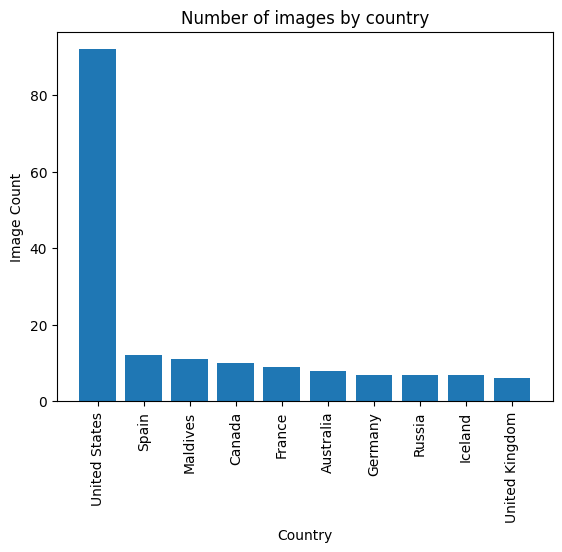

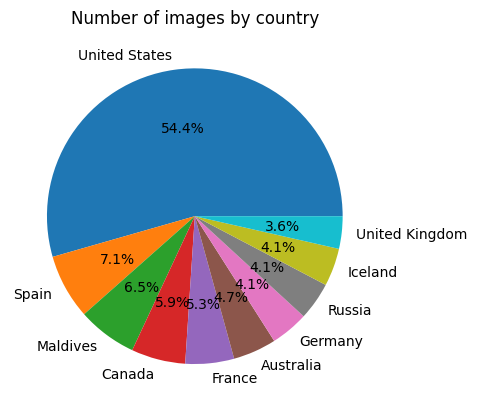

In [44]:
graph_images_countries(coordinates, 10, 'all')

# Graph images : by Dominant Color

In [48]:
MAX_COLUMNS = 20

def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name

dict_dom_color = {}
for idx, dom_color in enumerate(dict_metadata['dominant_color']):
    if dom_color is not None:
        list_dom_color = eval(dom_color)
        dict_dom_color.update({dict_metadata['file'][idx] : list_dom_color})

color_counts = Counter()
for image_colors in dict_dom_color.values():
    for color, percentage in image_colors:
        color_counts[color] += percentage

# Map hexadecimal codes to color names
color_names = {}
for code in color_counts.keys():
    try:
        rgb = webcolors.hex_to_rgb(code)
        actual, closest = get_colour_name(rgb)
        color_names[code] = closest
    except ValueError:
        pass

dict_res = {}
for key, val in color_names.items():
    if val in dict_res:
        dict_res[val] += round(color_counts[key]/100, 5)
    else:
        dict_res[val] = round(color_counts[key]/100, 5)

if sum(dict_res.values()) > 100:
    raise Exception('sum of dict_res.values() > 100')

columns = dict_res.__len__()
if columns > MAX_COLUMNS:
    columns = MAX_COLUMNS

sorted_colors = sorted(dict_res.items(), key=lambda x: x[1], reverse=True)
top_colors = dict(sorted_colors[:columns])

# Create a bar graph showing the dominant colors in the images
plt.bar(top_colors.keys(), top_colors.values(), color=top_colors.keys())
plt.xticks(rotation=90)
plt.show()

# Create a pie chart showing the dominant colors in the images
fig, ax = plt.subplots(figsize=(8, 8))
colors = list(top_colors.keys())
ax.pie(top_colors.values(), labels=top_colors.keys(), autopct='%1.1f%%', colors=colors, textprops={'color': 'white'})
ax.set_title('Top Colors')
ax.legend(title='Colors', loc='center right', bbox_to_anchor=(1.2, 0.5))
plt.show()

# Create a treemap showing the dominant colors in the images
color = [webcolors.name_to_hex(c) for c in top_colors]
labels = list(top_colors.keys())
sizes = list(top_colors.values())
squarify.plot(sizes=sizes, label=labels, color=color, alpha=.7)
plt.title("Top Colors")
plt.axis('off')
plt.show()

KeyError: 'dominant_color'

# Graph images : by Tags

In [49]:
# convert tag strings to a list of tags
tags = list(itertools.chain.from_iterable([ast.literal_eval(t) for t in dict_metadata['tags']]))

# count the occurrences of each tag
tag_counts = Counter(tags)

# plot the most common tags
n = 10
top_tags = dict(tag_counts.most_common(n))
plt.bar(top_tags.keys(), top_tags.values())
plt.title(f"Top {n} most common tags")
plt.xlabel("Tags")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()


ValueError: malformed node or string: None

In [50]:
tags = set(list(itertools.chain.from_iterable([ast.literal_eval(t) for t in dict_metadata['tags']])))

try:
    nlp = spacy.load("en_core_web_lg")  # load pre-trained word embedding model
except OSError:
    !python -m spacy download en_core_web_lg

categories = {
    "landscape" : {}, "animal" : {}, "people" : {}, "food" : {}, "building" : {}, "vehicle" : {}, "object" : {}, "other" : {}
}

# categorize words based on similarity to category prototypes
for word in tags:
    # find the most similar category prototype for the word
    max_similarity = -1
    chosen_category = "other"
    for category in categories:
        similarity = nlp(word).similarity(nlp(category))
        if similarity > max_similarity:
            max_similarity = similarity
            chosen_category = category

    # add the word into the appropriate category dictionary
    categories[chosen_category].update({word : max_similarity})

print(categories)

ValueError: malformed node or string: None

In [51]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

# Convert the dictionary into a numpy array
def dict_to_array(categories):
    arr = np.zeros((len(categories), len(categories)))
    for i, (cat, subcat) in enumerate(categories.items()):
        for j, (subcat, val) in enumerate(subcat.items()):
            arr[i,j] = val
    return arr

# Generate the linkage matrix
Z = linkage(dict_to_array(categories), 'ward')

# Plot the dendrogram
fig = plt.figure(figsize=(10, 5))
dn = dendrogram(Z, labels=list(categories.keys()))
plt.show()

NameError: name 'categories' is not defined

In [52]:
tags = set(list(itertools.chain.from_iterable([ast.literal_eval(t) for t in dict_metadata['tags']])))
user_data = {}

# Create a label for the title
title_label = widgets.Label(value='User Information Form')

# Create text boxes for first and last name
pseudo = widgets.Text(description='Pseudo :')

# Create a color picker for favorite colors
color_picker = widgets.ColorPicker(
    concise=True,
    description='Favorite Colors:',
    value='#FF0000',
    continuous_update=False,
    disabled=False
)

# Create a dropdown list of tags
tag_dropdown = widgets.SelectMultiple(
    options=tags,
    value=[],
    description='Tags:',
    disabled=False
)

# Create a dropdown for image orientation
orientation_dropdown = widgets.Dropdown(
    options=['Portrait', 'Landscape'],
    value='Portrait',
    description='Orientation:'
)

# Create sliders for image height and width
height_slider = widgets.IntSlider(min=100, max=4000, step=100, description='Height:')
width_slider = widgets.IntSlider(min=100, max=4000, step=100, description='Width:')

#  Create a button to submit the form
submit_button = widgets.Button(description='Submit')

# Create a VBox container for the widgets
form_container = widgets.VBox([
    title_label,
    pseudo,
    color_picker,
    orientation_dropdown,
    height_slider,
    width_slider,
    tag_dropdown,
    submit_button
])

form_container.layout = widgets.Layout(
    width='600px',
    height='500px',
    justify_content='center',  # Centrer les widgets horizontalement
    align_items='center'  # Centrer les widgets verticalement
)

# Define a function to handle form submission
def on_submit_button_clicked(b):
    user_data.update({
        pseudo.value : {
            'fav_color' : color_picker.value,
            'fav_orientation' : orientation_dropdown.value,
            'fav_height' : height_slider.value,
            'fav_width' : width_slider.value,
            'tags': tag_dropdown.value
        }
    }
)

# Attach the on_submit_button_clicked function to the button click event
clicked = submit_button.on_click(on_submit_button_clicked)

# Display the form container
display(form_container)

ValueError: malformed node or string: None

In [53]:
print(user_data)

NameError: name 'user_data' is not defined

In [54]:
list_columns = ['fav_color', 'fav_orientation', 'fav_height', 'fav_width']

def save_metadata(user_data):
    try:
        # Open a connection to the database
        conn = sqlite3.connect(os.path.join(metadata_path, 'metadata.db'))
        # Create a cursor
        c = conn.cursor()
        # Create a table if it doesn't exist : filename, key, value
        c.execute(
            '''CREATE TABLE IF NOT EXISTS users (
            pseudo text PRIMARY KEY,
            fav_color text,
            fav_orientation text,
            fav_height integer,
            fav_width integer
        )''')

        nb_users = len(user_data.keys())

        check = True
        # check if all data are usable
        if nb_users > 1:
            for pseudo in user_data.keys() :
                for column in list_columns :
                    if user_data[pseudo][column] is None :
                        check = False
                        return
        else :
            check = False

        if check :
            for pseudo in user_data.keys() :
                c.execute("SELECT * FROM users WHERE pseudo=?", (pseudo,))
                if c.fetchone():
                    c.execute("UPDATE users SET fav_color=?, fav_orientation=?, fav_height=?, fav_width=? WHERE pseudo=?",
                              (user_data[pseudo]['fav_color'], user_data[pseudo]['fav_orientation'], user_data[pseudo]['fav_height'], user_data[pseudo]['fav_width'], pseudo))
                    conn.commit()
                else :
                    c.execute("INSERT INTO users VALUES (?, ?, ?, ?, ?)", (pseudo, user_data[pseudo]['fav_color'], user_data[pseudo]['fav_orientation'], user_data[pseudo]['fav_height'], user_data[pseudo]['fav_width']))
                    conn.commit()
                print(f"User {pseudo} saved to database successfully")
            conn.close()
        else :
            print("Invalid User data")

    except Exception as e:
        print("Error saving user to database : ", e)

save_metadata(user_data)
print(user_data)

NameError: name 'user_data' is not defined